In [1]:
import sys

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 KB 2.4 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 2.5 MB/s eta 0:00:002.8 MB/s eta 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 1.0 MB/s eta 0:00:001.4 MB/s eta 0:00:01


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]
from typing import Tuple
from  random import randint

In [4]:
def define_camera_matrices(f: np.ndarray, p: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    K = np.array([[f[0], 0, p[0]], 
                  [0, f[1], p[1]], 
                  [0, 0, 1]])
    
    K_inv = np.array([[1/f[0], 0, -p[0]/f[0]], 
                      [0, 1/f[1], -p[1]/f[1]], 
                      [0, 0, 1]])
    return K, K_inv

In [5]:
f = [3740, 3740]
image_size = [1390, 1110]
p = [image_size[0] / 2, image_size[1] / 2]
K, K_inv = define_camera_matrices(f, p)

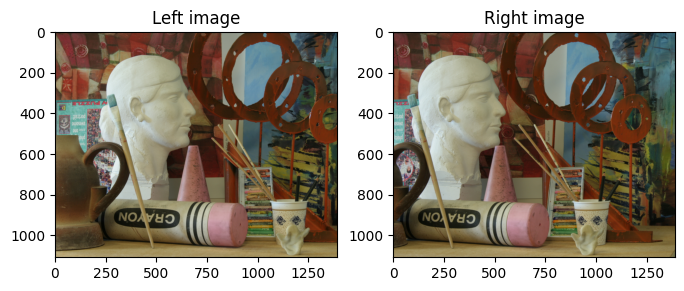

In [12]:
# Загрузим изображения

def load_img(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

left, right = load_img('data/Art/view1.png'), load_img('data/Art/view5.png')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(left)
ax[0].set_title('Left image')
ax[1].imshow(right)
ax[1].set_title('Right image')

plt.show()

Наша задача - построить карту глубины для этих картинок. Для этого надо найти соответствующие точки на обеих картинках и высчитать расстояние до них методом триангуляции. Чтобы найти одну и ту же точку на двух картинках, нам необходимо извлечь из картинок признаки и каким либо образом их сравнить.

In [46]:
# SIFT

sift = cv2.SIFT_create()
left_gray, right_gray = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY), cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)

left_keypoints, left_descriptors = sift.detectAndCompute(left, None)
right_keypoints, right_descriptors = sift.detectAndCompute(right, None)

# img = cv2.drawKeypoints(left_gray,left_keypoints,left_gray,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow(img)

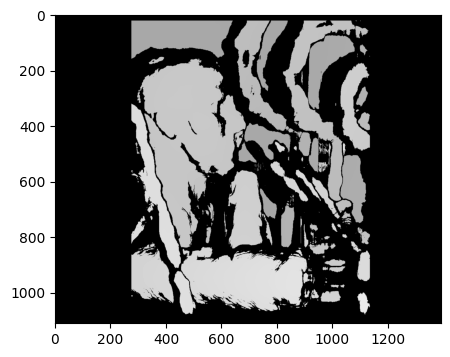

In [79]:
stereo = cv2.StereoBM.create(numDisparities=512, blockSize=41)
stereo.setMinDisparity(-256)
disparity = stereo.compute(left_gray,right_gray)
plt.imshow(disparity,'gray')
plt.show()

Попробуем построить облако точек из левого изображения и его известной карты глубины.

[[ 80  80  79 ...  95  95  95]
 [ 80  80  79 ...  95  95  95]
 [ 80  80  79 ...  95  95  95]
 ...
 [221 221 221 ... 222 222 222]
 [222 222 222 ... 223 223 223]
 [223 223 223 ... 224 224 224]]


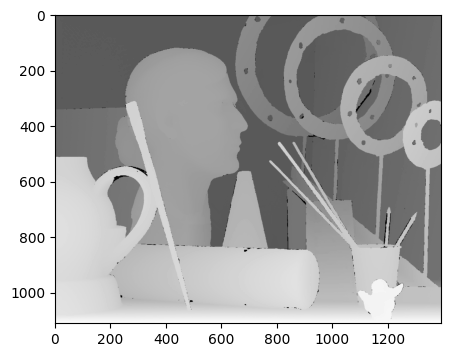

In [16]:
def load_depth(path: str) -> np.ndarray:
    depth_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2RGB)
    # R = depth_image[:, :, 0].astype(int)
    # G = depth_image[:, :, 1].astype(int)
    # B = depth_image[:, :, 2].astype(int)
    # depth = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1) * 1000
    return depth_image

left_dm = load_depth('data/Art/disp1.png')
plt.imshow(left_dm, cmap='gray')

In [28]:
height, width = left_dm.shape

pixels_coords_2d = np.array(
    [
        [i, j]
        for i in range(height)
        for j in range(width)
    ]
).T

pixels_coords_h = np.vstack([pixels_coords_2d, np.ones(pixels_coords_2d.shape[1], np.int32)])
rays = K_inv @ pixels_coords_h

cloud = rays * left_dm.flatten()
colors = left.reshape(-1, 3).T



In [29]:
file = open('cloud.xyz', 'w')
for i in range(cloud.shape[1]):
    file.write(f'{cloud[0, i]}, {cloud[1, i]}, {cloud[2, i]}, {colors[0, i]}, {colors[1, i]}, {colors[2, i]}\n')
file.close()

In [21]:
pixels_coords_h

array([[   0,    0,    0, ..., 1109, 1109, 1109],
       [   0,    1,    2, ..., 1387, 1388, 1389],
       [   1,    1,    1, ...,    1,    1,    1]])

In [23]:
left_dm.flatten().shape

(1542900,)